#### Performing density regression using TT-parametrized ODE flows

In Rohrbach et al. 2020, a-priori rank bounds are developed for FTT representations in Gaussian models, demonstrating that under certain conditions, high-accuracy approximations can be achieved without exponential complexity growth as dimensions increase. This motivates the following technical approach for our regression model. 

For an exponential function
$$
\exp_g(\mathbf{x}) := \exp(g(\mathbf{x})),
$$
with continuous $g$, such as the Gaussian with $g(\mathbf{x}) = \mathbf{x}^T \Gamma \mathbf{x}$, we can define a function $f \in \mathcal{C}(\mathbb{R}^{d+1}, \mathbb{R}^{d+1})$ and an ODE
$$
\dot{x}(t) = f(x(t)), \quad t \in [0, 1],
$$
with
$$
x(0) = \begin{pmatrix} 1 \\ \mathbf{x} \end{pmatrix},
$$
such that $x(1)_1 = \exp(g(x))$. Following the approach of David Sommer, in particular, this holds true for
$$
f(x) = \begin{pmatrix} g(x_{2:d+1}) x_1 \\ 0_d \end{pmatrix}.
$$


Further, 
$$
g(\mathbf{x}) = \mathbf{x}^T \Gamma \mathbf{x}, \quad \mathbf{x} \in \mathbb{R}^d, \quad \Gamma \in \mathbb{R}^{d \times d}
$$
has FTT ranks bounded by $2 + \frac{d}{2}$.


For our experiments, we will assume that we can represent the function as
$$
f_\theta(t, x) = \begin{pmatrix} u_\theta(t, x_{2:d+1}) x_1 \\ 0_d \end{pmatrix}, 
$$
where $u_\theta$ is a FTT of the form 
$$
u_\theta(t, x_1, \ldots, x_d) = \sum_{i_1=0}^{m} \cdots \sum_{i_d=0}^{m} 
\hat{U}(i_1, \cdot) \hat{U}(\cdot, i_2, \cdot) \cdots \hat{U}(\cdot, i_{d+1}, \cdot)
P_{i_1}(t) P_{i_2}(x_1) \cdots P_{i_{d+1}}(x_d), 
$$
with ranks $r_0 = 1, r_{d+1} = d, r_1 = \ldots, r_d = r$ for any a priori set $r \in \N$.

Assume that $f_\Gamma: \R^d \to \R$ denotes the density of a $d$-dimensional Gaussian distribution with covariance matrix $\Gamma$. Further, define $g_\theta(\mathbf{x}) = x(T)$, where $\dot{x}(t) = f_\theta(t, x(t))$ for $t \in [0, 1]$ with initial condition $x(0) = \mathbf{x}$.

**Goal:**
$$
\min_\theta \Vert f_\Gamma - g_\theta \Vert_2^2 + \lambda * \Vert \theta \Vert_2^2 \quad \text{subject to} \quad \dot{x}(t) = f_\theta(t, x(t)), \quad t \in [0, 1], \quad \text{with} \quad x(0) = \mathbf{x}, 
$$

where the vector $\theta$ captures all the parameters defining the FTT-cores.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import ExtendedFlowODE

from utils.gaussian import generate_gaussian_data, gaussian_density

from utils.error_funcs import abs_error_func, rel_error_func, abs_error_func_shallow_net, rel_error_func_shallow_net

# torch.manual_seed(42)
# np.random.seed(42)

In [4]:
# Loss function
def loss_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)

    result = ((y_pred - y) ** 2) + lambda_transport_reg * l2_transport_cost
    return result.mean() + lambda_tt_reg * tt_regularization

In [5]:
# Loss function shallow net
def loss_func_shallow_net(model, x: torch.Tensor, y: torch.Tensor, lambda_tt_reg):
    
    y_pred = model(0, x) # 0 is just an arbitrary point if time dependency is deactivated
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.tt_cores)
    
    result = ((y_pred.squeeze() - y) ** 2)
    return result.mean() + lambda_tt_reg * tt_regularization

##### Approximating a Gaussian density in 2D using flow induced CTTs

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [96]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-3., 3.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [97]:
# Training parameters
n_samples = 256
n_epochs = 250
batch_size = 64
learning_rate = 1e-2

In [99]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

Gamma = torch.tensor([[1.25, 1.], [1.,1.25]])
# Gamma = torch.eye(2)

data, target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [101]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Reduce learning rate if relative error <= 0.1
    reduced_lr = False
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        
        # Reduce lambda_tt_reg
        lambda_transport_reg *= 1 / (10 ** (1/50))
        lambda_tt_reg *= 1 / (10 ** (1/50))
        
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)

        # Reduce learning rate to ensure convergence
        if avg_epoch_rel_error <= 0.1 and not reduced_lr:
            lr = optimizer.param_groups[0]['lr'] * 1e-1 
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  
                reduced_lr = True
            print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [102]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/250], Loss: 0.9434, Absolute Error: 0.9417, Relative Error: 591.80, Transport Cost: 0.0011
Epoch [2/250], Loss: 0.9008, Absolute Error: 0.8992, Relative Error: 551.30, Transport Cost: 0.0042
Epoch [3/250], Loss: 0.8272, Absolute Error: 0.8256, Relative Error: 517.36, Transport Cost: 0.0100
Epoch [4/250], Loss: 0.7157, Absolute Error: 0.7140, Relative Error: 450.77, Transport Cost: 0.0240
Epoch [5/250], Loss: 0.5816, Absolute Error: 0.5797, Relative Error: 358.83, Transport Cost: 0.0639
Epoch [6/250], Loss: 0.4234, Absolute Error: 0.4214, Relative Error: 266.91, Transport Cost: 0.1283
Epoch [7/250], Loss: 0.2482, Absolute Error: 0.2461, Relative Error: 154.28, Transport Cost: 0.2077
Epoch [8/250], Loss: 0.1111, Absolute Error: 0.1089, Relative Error: 72.53, Transport Cost: 0.3230
Epoch [9/250], Loss: 0.0448, Absolute Error: 0.0424, Relative Error: 25.63, Transport Cost: 0.4180
Epoch [10/250], Loss: 0.0177, Absolute Error: 0.0152, Relative Error: 10.43,

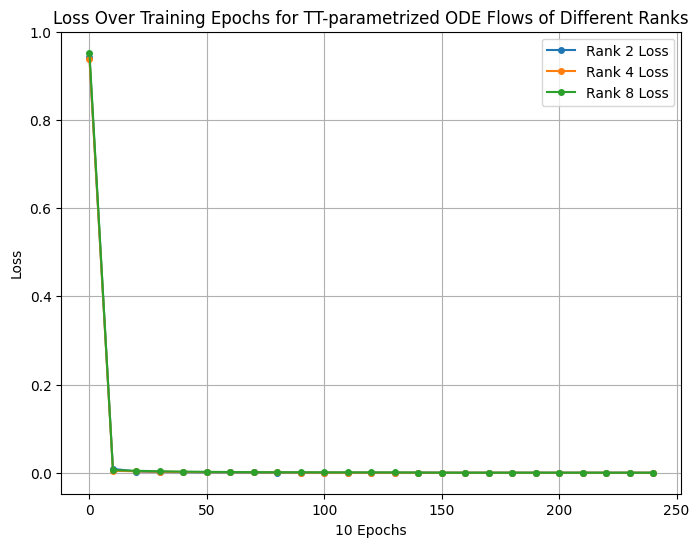

In [106]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

# Select the epochs to plot (0th, 100th, 200th, etc.)
epochs_to_plot = range(0, n_epochs, 10)

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(epochs_to_plot, [training_dict["Rank 2"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 2 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 4"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 4 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 8"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 8 Loss')

plt.xlabel('10 Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [109]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# models = [model_rank2]
# ranks = [2]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2.5, 2.5, n)
test_data_x_2 = torch.linspace(-2.5, 2.5, n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)


TT-rank 2: Absolute squared error of 0.00026539 and relative squared error of 0.123326 on test data grid.
TT-rank 4: Absolute squared error of 0.00016814 and relative squared error of 0.078137 on test data grid.
TT-rank 8: Absolute squared error of 0.00010443 and relative squared error of 0.048528 on test data grid.


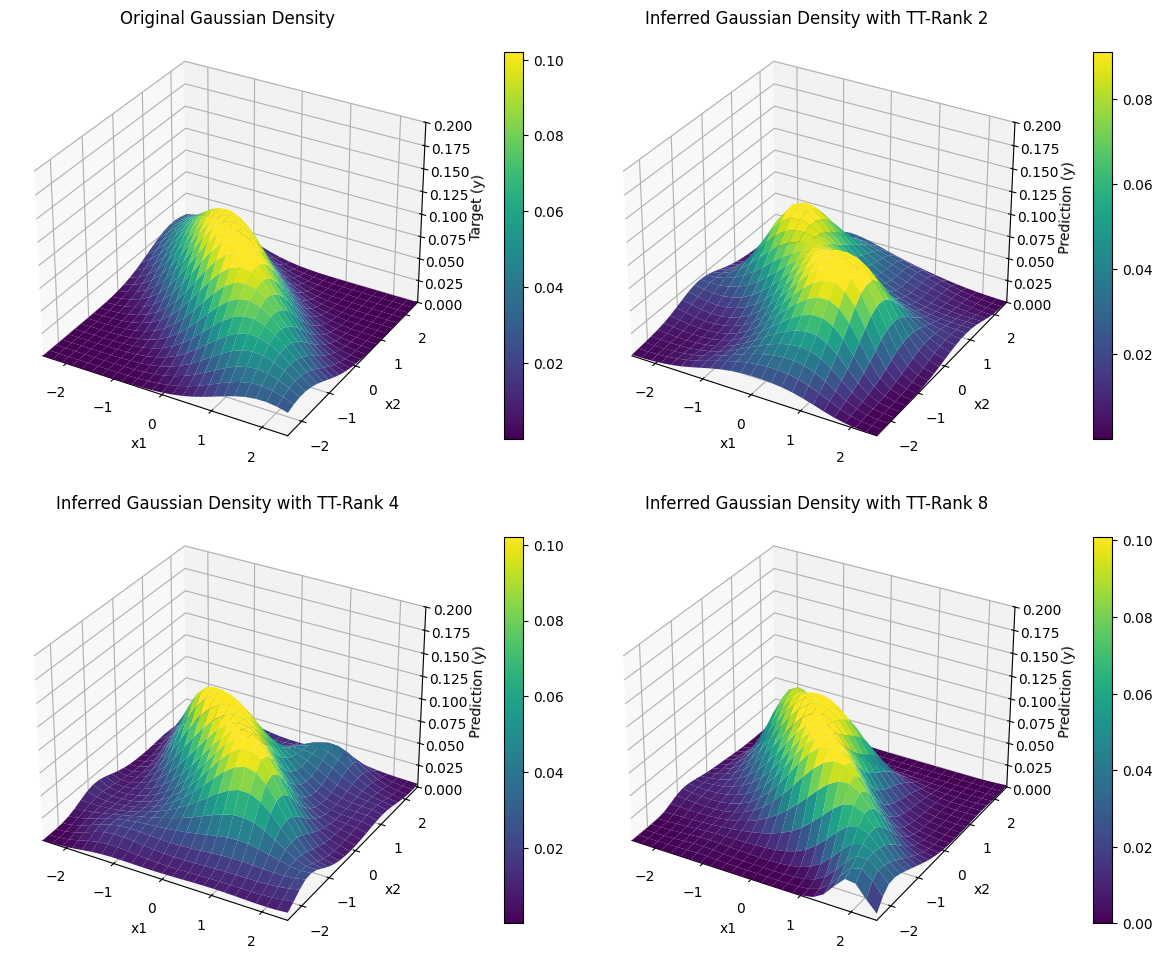

In [110]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.8f} and relative squared error of {rel_error:.6f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-2.5, 2.5])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

2. **Fourier basis:**

    Next, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Fourier  basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [111]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 3

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.), normalize=True, period=4)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


Text(0.5, 1.0, 'Fourier 1D')

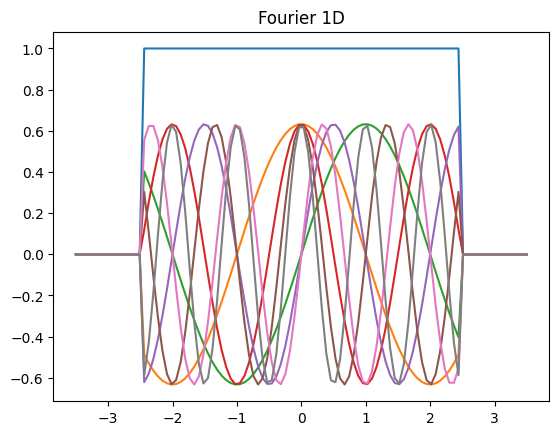

In [ ]:
# Test plot of 1D Fourier basis
fourier = Fourier1D(dimension, domain=(-2.5, 2.5), normalize=True, period=4)
x = np.linspace(-3.5, 3.5, 100)
y = [fourier(torch.tensor(x[i])) for i in range(100)]
plt.plot(x, y)
plt.title("Fourier 1D")

In [112]:
# Training parameters
n_samples = 256
n_epochs = 250
batch_size = 64
learning_rate = 1e-2

In [113]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

Gamma = torch.tensor([[1.25, 1.], [1.,1.25]])

data , target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [114]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-9, lambda_tt_reg = 1e-9):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Reduce learning rate if relative error <= 0.1
    reduced_lr = False
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0

        # Reduce lambda_tt_reg
        lambda_transport_reg *= 1 / (10 ** (1/50))
        lambda_tt_reg *= 1 / (10 ** (1/50))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Reduce learning rate to ensure convergence
        if avg_epoch_rel_error <= 0.1 and not reduced_lr:
            lr = optimizer.param_groups[0]['lr'] * 1e-1 
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  
                reduced_lr = True
            print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [115]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/250], Loss: 0.9440, Absolute Error: 0.9440, Relative Error: 617.11, Transport Cost: 0.0001
Epoch [2/250], Loss: 0.9272, Absolute Error: 0.9272, Relative Error: 593.30, Transport Cost: 0.0003
Epoch [3/250], Loss: 0.8981, Absolute Error: 0.8981, Relative Error: 587.01, Transport Cost: 0.0011
Epoch [4/250], Loss: 0.8465, Absolute Error: 0.8465, Relative Error: 562.94, Transport Cost: 0.0037
Epoch [5/250], Loss: 0.7666, Absolute Error: 0.7666, Relative Error: 504.35, Transport Cost: 0.0103
Epoch [6/250], Loss: 0.6545, Absolute Error: 0.6545, Relative Error: 446.79, Transport Cost: 0.0258
Epoch [7/250], Loss: 0.5195, Absolute Error: 0.5195, Relative Error: 392.97, Transport Cost: 0.0589
Epoch [8/250], Loss: 0.3759, Absolute Error: 0.3759, Relative Error: 252.28, Transport Cost: 0.1234
Epoch [9/250], Loss: 0.2481, Absolute Error: 0.2481, Relative Error: 158.14, Transport Cost: 0.2082
Epoch [10/250], Loss: 0.1495, Absolute Error: 0.1495, Relative Error: 99.9

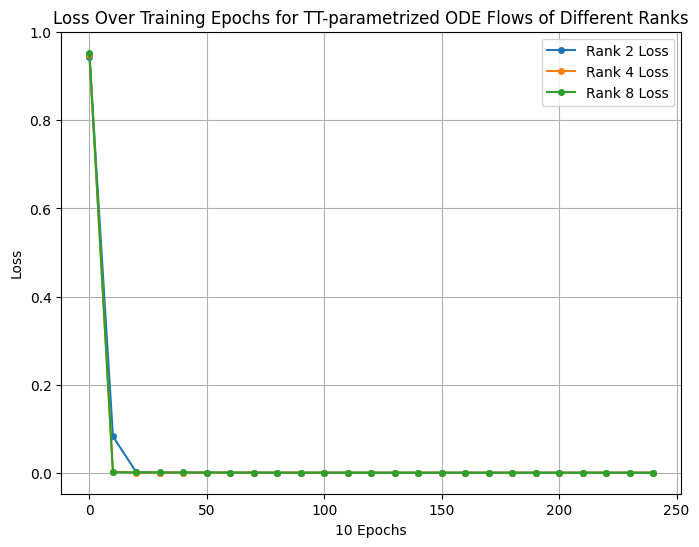

In [117]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

# Select the epochs to plot (0th, 100th, 200th, etc.)
epochs_to_plot = range(0, n_epochs, 10)

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(epochs_to_plot, [training_dict["Rank 2"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 2 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 4"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 4 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 8"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 8 Loss')

plt.xlabel('10 Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [118]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# models = [model_rank2]
# ranks = [2]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2.5, 2.5, n)
test_data_x_2 = torch.linspace(-2.5, 2.5, n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

TT-rank 2: Absolute squared error of 0.0007 and relative squared error of 0.32 on test data grid.
TT-rank 4: Absolute squared error of 0.0007 and relative squared error of 0.34 on test data grid.
TT-rank 8: Absolute squared error of 0.0007 and relative squared error of 0.32 on test data grid.


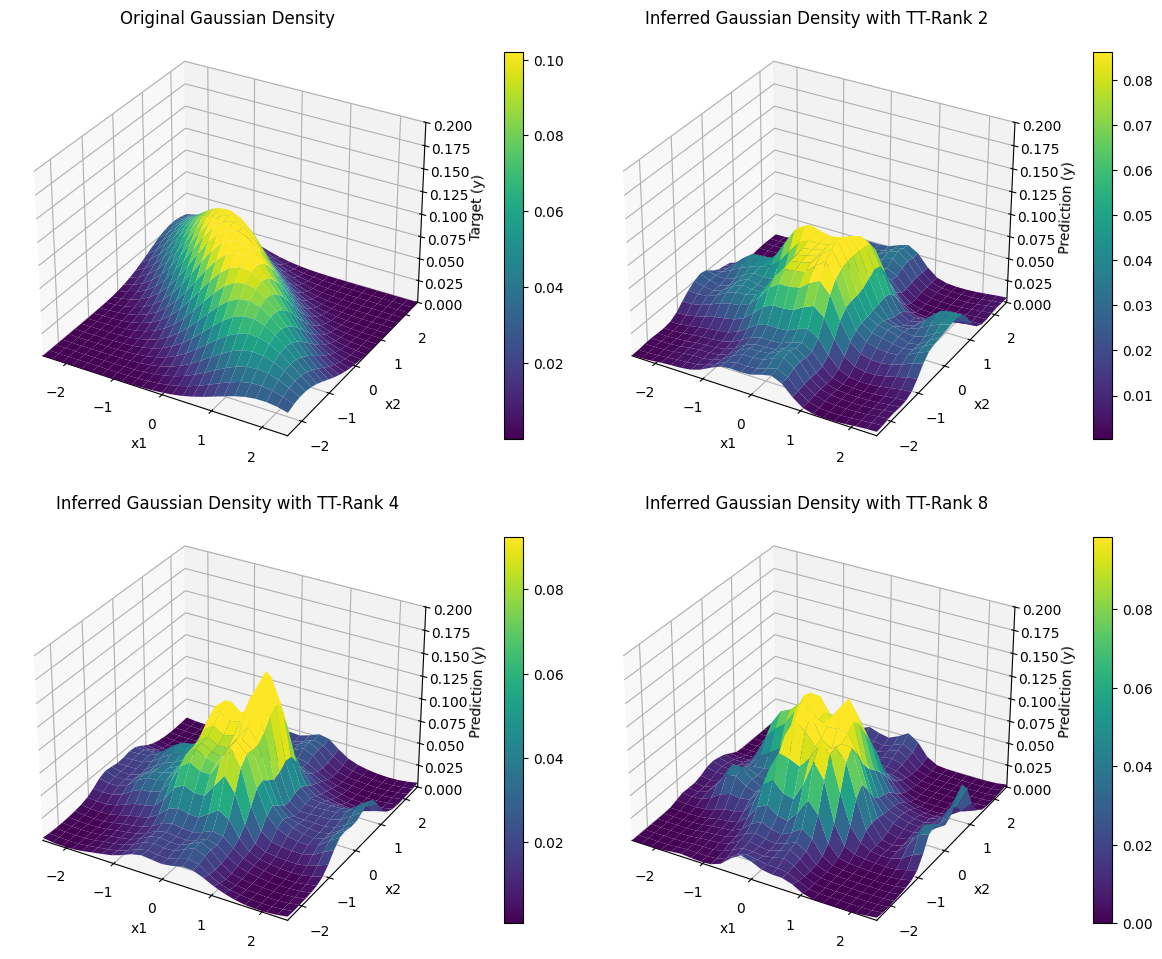

In [119]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-2.5, 2.5])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

3. **B-Splines:**

    Now, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using **B-Splines of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [7]:
# Test implementation of B-spline basis
degree = 3
d = 3
bases = [
        BSpline1D(torch.linspace(-5, 5, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [8]:
# Training parameters
n_samples = 256
n_epochs = 250
batch_size = 64
learning_rate = 1e-3

In [9]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

Gamma = torch.tensor([[1., 0.], [0.,1.]])

data , target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

/var/folders/rc/9s_11zv502jcx5bnwgh4bmr00000gn/T/ipykernel_65943/1090877103.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  exponent = -0.5 * (x.T @ Gamma @ x)


In [11]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [12]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/250], Loss: 0.8608, Absolute Error: 0.8591, Relative Error: 113.62, Transport Cost: 0.0000
Epoch [2/250], Loss: 0.8606, Absolute Error: 0.8589, Relative Error: 113.59, Transport Cost: 0.0000
Epoch [3/250], Loss: 0.8605, Absolute Error: 0.8588, Relative Error: 114.75, Transport Cost: 0.0000
Epoch [4/250], Loss: 0.8604, Absolute Error: 0.8587, Relative Error: 113.53, Transport Cost: 0.0000
Epoch [5/250], Loss: 0.8602, Absolute Error: 0.8586, Relative Error: 115.11, Transport Cost: 0.0000
Epoch [6/250], Loss: 0.8601, Absolute Error: 0.8585, Relative Error: 116.37, Transport Cost: 0.0000
Epoch [7/250], Loss: 0.8600, Absolute Error: 0.8584, Relative Error: 114.16, Transport Cost: 0.0000
Epoch [8/250], Loss: 0.8598, Absolute Error: 0.8583, Relative Error: 116.37, Transport Cost: 0.0000
Epoch [9/250], Loss: 0.8596, Absolute Error: 0.8581, Relative Error: 113.68, Transport Cost: 0.0000
Epoch [10/250], Loss: 0.8594, Absolute Error: 0.8579, Relative Error: 113.

KeyboardInterrupt: 

In [1]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_training_loss_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

NameError: name 'training_dict' is not defined

In [ ]:
# Define a list of models and corresponding ranks
models = [model_rank2, model_rank4, model_rank8]
ranks = [2, 4, 8]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2., 2., n)
test_data_x_2 = torch.linspace(-2., 2., n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

# Define the target Gaussian function
Gamma = torch.eye(2) 

In [ ]:
# Create the figure with 4 subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, test_data, test_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_2D_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()


##### Approximating a Gaussian density in 2D using shallow FTTs

1. **Legendre basis:**

    For benchmarking purposes, we approximate the Gaussian density using a shallow FTT network, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 1, 2, 4, 8, 16, 32**. 

In [72]:
# Configure a Legendre basis for the FTT
dimension = 8
d = 2

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-3., 3.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [73]:
# Training parameters
n_samples = 1024
n_epochs = 1000
batch_size = 128
learning_rate = 1e-3

In [74]:
# Initialize data and FTTs of different ranks 

Gamma = torch.tensor([[1.25, 1.], [1.,1.25]])
# Gamma = torch.eye(2)

data, target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 1, 2, 4, 8, 16, 32 - time dependency always deactivated for shallow architectures
ftt_rank1 = FuncTT(d_in=2, d_out=1, bases=bases, rank=1, time_dependent=False)
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=False)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=False)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=False)
ftt_rank16 = FuncTT(d_in=2, d_out=1, bases=bases, rank=16, time_dependent=False)
# ftt_rank32 = FuncTT(d_in=2, d_out=1, bases=bases, rank=32, time_dependent=False)

# Set the models to training mode and choose optimizer
ftt_rank1.train()
ftt_rank2.train()
ftt_rank4.train()
ftt_rank8.train()
ftt_rank16.train()
# ftt_rank32.train()

optimizer_rank1 = optim.AdamW(ftt_rank1.parameters(), lr=learning_rate)
optimizer_rank2 = optim.AdamW(ftt_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(ftt_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(ftt_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(ftt_rank16.parameters(), lr=learning_rate)
# optimizer_rank32 = optim.AdamW(ftt_rank32.parameters(), lr=learning_rate)

In [75]:
# Training loop in a function
def training_procedure_shallow_net(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, 
                                   n_epochs: int, optimizer: object, training_dict: dict, training_id: str,
                                   lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")
    # Reduce learning rate n times
    n_reduced_lr = 0

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0

        # Reduce lambda_tt_reg
        lambda_tt_reg *= 1 / (10 ** (3/100))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func_shallow_net(model, x_batch, y_batch, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func_shallow_net(model, x_batch, y_batch)
            rel_error = rel_error_func_shallow_net(model, x_batch, y_batch)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)

        # Norm TT cores
        norm_tt_cores = sum(torch.norm(core, p="fro") for core in model.tt_cores)
        
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)

        # Reduce learning rate to ensure convergence
        # if (avg_epoch_rel_error <= 1 and n_reduced_lr < 1) or (avg_epoch_rel_error <= 0.8 and n_reduced_lr < 2):
        #     lr = optimizer.param_groups[0]['lr'] * 1e-1 
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr  
        #         n_reduced_lr += 1
        #     print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Norm TT Cores: {norm_tt_cores:.2f} ")
            
    training_dict[training_id] = loss_history


In [76]:
training_dict = {}
training_procedure_shallow_net(ftt_rank1, data, target, batch_size, n_epochs, optimizer_rank1, training_dict, "Rank 1", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank16, data, target, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16", lambda_tt_reg=1e-3)
# training_procedure_shallow_net(ftt_rank32, data, target, batch_size, n_epochs, optimizer_rank32, training_dict, "Rank 32", lambda_tt_reg=1e-3)


Training Run ID: Rank 1

Epoch [1/1000], Loss: 0.0743, Absolute Error: 0.0733, Relative Error: 49.36, Norm TT Cores: 1.13 
Epoch [2/1000], Loss: 0.0648, Absolute Error: 0.0638, Relative Error: 43.80, Norm TT Cores: 1.10 
Epoch [3/1000], Loss: 0.0574, Absolute Error: 0.0565, Relative Error: 36.87, Norm TT Cores: 1.07 
Epoch [4/1000], Loss: 0.0507, Absolute Error: 0.0499, Relative Error: 33.12, Norm TT Cores: 1.04 
Epoch [5/1000], Loss: 0.0450, Absolute Error: 0.0442, Relative Error: 28.52, Norm TT Cores: 1.01 
Epoch [6/1000], Loss: 0.0396, Absolute Error: 0.0390, Relative Error: 25.91, Norm TT Cores: 0.99 
Epoch [7/1000], Loss: 0.0352, Absolute Error: 0.0346, Relative Error: 22.95, Norm TT Cores: 0.96 
Epoch [8/1000], Loss: 0.0314, Absolute Error: 0.0309, Relative Error: 19.94, Norm TT Cores: 0.94 
Epoch [9/1000], Loss: 0.0282, Absolute Error: 0.0277, Relative Error: 18.34, Norm TT Cores: 0.92 
Epoch [10/1000], Loss: 0.0254, Absolute Error: 0.0250, Relative Error: 16.23, Norm TT Cores:

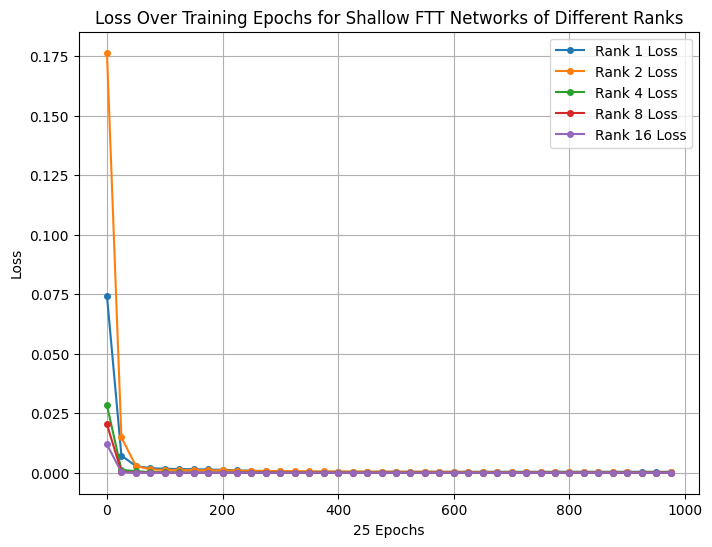

In [77]:
# Number of epochs
n_epochs = len(training_dict["Rank 1"])

# Select the epochs to plot (0th, 100th, 200th, etc.)
epochs_to_plot = range(0, n_epochs, 25)

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank at the selected intervals with smaller "o" markers
plt.plot(epochs_to_plot, [training_dict["Rank 1"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 1 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 2"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 2 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 4"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 4 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 8"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 8 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 16"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 16 Loss')
# plt.plot(epochs_to_plot, [training_dict["Rank 32"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 32 Loss')

plt.xlabel('25 Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for Shallow FTT Networks of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'shallow_ftt_gaussian_density_regression_2D_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()


In [78]:
# Define a list of models and corresponding ranks
models = [ftt_rank1, ftt_rank2, ftt_rank4, ftt_rank8, ftt_rank16]
ranks = [1, 2, 4, 8, 16]

# models = [ftt_rank1]
# ranks = [1]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2.5, 2.5, n)
test_data_x_2 = torch.linspace(-2.5, 2.5, n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

TT-rank 1: Absolute squared error of 0.00051481 and relative squared error of 0.239233 on test data grid.
TT-rank 2: Absolute squared error of 0.00011046 and relative squared error of 0.051331 on test data grid.
TT-rank 4: Absolute squared error of 0.00000524 and relative squared error of 0.002433 on test data grid.
TT-rank 8: Absolute squared error of 0.00000304 and relative squared error of 0.001415 on test data grid.
TT-rank 16: Absolute squared error of 0.00000384 and relative squared error of 0.001786 on test data grid.


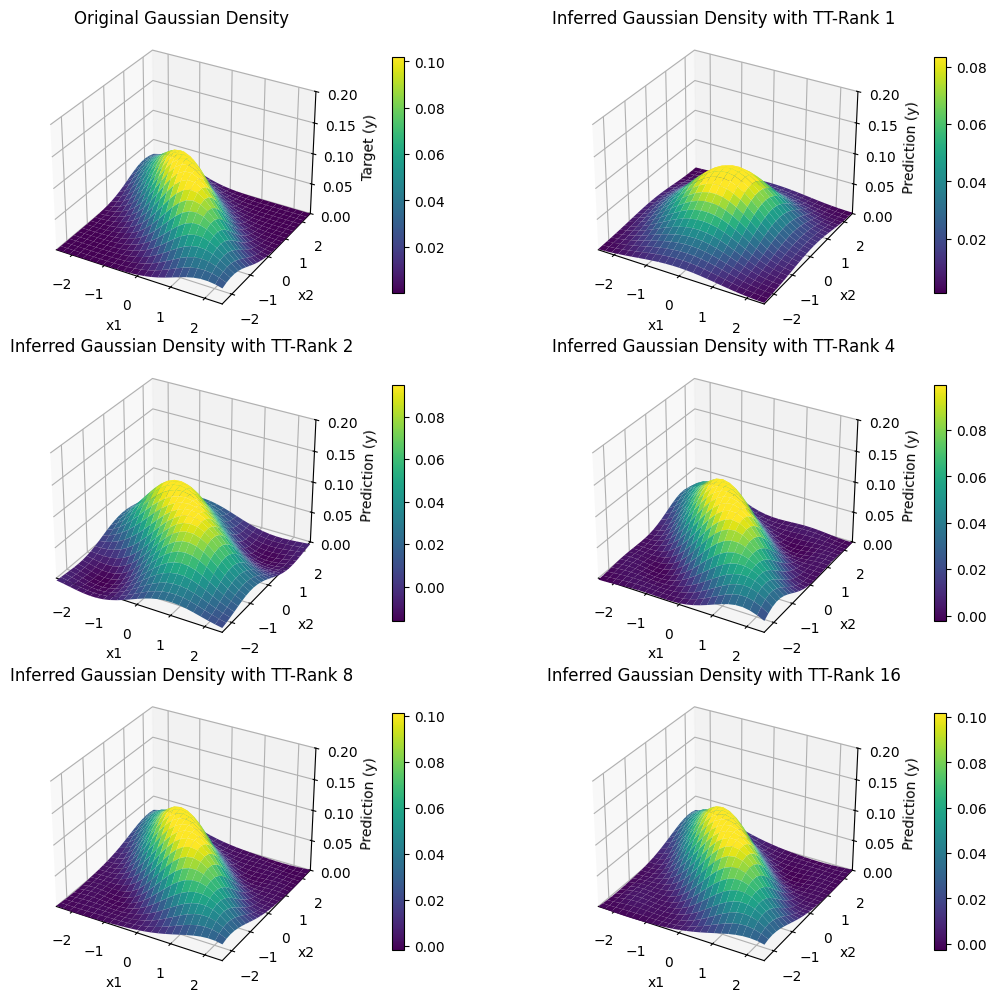

In [79]:
# Create the figure with 6 subplots (3x2 layout)
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func_shallow_net(model, test_data, test_target)
    rel_error = rel_error_func_shallow_net(model, test_data, test_target)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.8f} and relative squared error of {rel_error:.6f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-2.5, 2.5])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(0, test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'shallow_ftt_gaussian_density_regression_2D_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

1. **Fourier basis:**

    For benchmarking purposes, we approximate the Gaussian density using a shallow FTT network, constructed using a **Fourier basis of dimension 8**. The experiment is conducted for **FTTs of ranks 1, 2, 4, 8, 16, 32**.

In [118]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 2

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.), normalize=True, period=4)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [119]:
# Training parameters
n_samples = 1024
n_epochs = 1000
batch_size = 128
learning_rate = 1e-3

In [80]:
# Initialize data and FTTs of different ranks 

Gamma = torch.tensor([[1.25, 1.], [1.,1.25]])
# Gamma = torch.eye(2)

data, target = generate_gaussian_data(d=2, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 1, 2, 4, 8, 16, 32 - time dependency always deactivated for shallow architectures
ftt_rank1 = FuncTT(d_in=2, d_out=1, bases=bases, rank=1, time_dependent=False)
ftt_rank2 = FuncTT(d_in=2, d_out=1, bases=bases, rank=2, time_dependent=False)
ftt_rank4 = FuncTT(d_in=2, d_out=1, bases=bases, rank=4, time_dependent=False)
ftt_rank8 = FuncTT(d_in=2, d_out=1, bases=bases, rank=8, time_dependent=False)
ftt_rank16 = FuncTT(d_in=2, d_out=1, bases=bases, rank=16, time_dependent=False)
# ftt_rank32 = FuncTT(d_in=2, d_out=1, bases=bases, rank=32, time_dependent=False)

# Set the models to training mode and choose optimizer
ftt_rank1.train()
ftt_rank2.train()
ftt_rank4.train()
ftt_rank8.train()
ftt_rank16.train()
# ftt_rank32.train()

optimizer_rank1 = optim.AdamW(ftt_rank1.parameters(), lr=learning_rate)
optimizer_rank2 = optim.AdamW(ftt_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(ftt_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(ftt_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(ftt_rank16.parameters(), lr=learning_rate)
# optimizer_rank32 = optim.AdamW(ftt_rank32.parameters(), lr=learning_rate)

In [81]:
# Training loop in a function
def training_procedure_shallow_net(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, 
                                   n_epochs: int, optimizer: object, training_dict: dict, training_id: str,
                                   lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")
    # Reduce learning rate n times
    n_reduced_lr = 0

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0

        # Reduce lambda_tt_reg
        lambda_tt_reg *= 1 / (10 ** (3/100))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func_shallow_net(model, x_batch, y_batch, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func_shallow_net(model, x_batch, y_batch)
            rel_error = rel_error_func_shallow_net(model, x_batch, y_batch)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)

        # Norm TT cores
        norm_tt_cores = sum(torch.norm(core, p="fro") for core in model.tt_cores)
        
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)

        # Reduce learning rate to ensure convergence
        # if (avg_epoch_rel_error <= 1. and n_reduced_lr < 1) or (avg_epoch_rel_error <= 0.8 and n_reduced_lr < 2):
        #     lr = optimizer.param_groups[0]['lr'] * 1e-1 
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr  
        #         n_reduced_lr += 1
        #     print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Norm TT Cores: {norm_tt_cores:.2f} ")
            
    training_dict[training_id] = loss_history

In [82]:
training_dict = {}
training_procedure_shallow_net(ftt_rank1, data, target, batch_size, n_epochs, optimizer_rank1, training_dict, "Rank 1", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8", lambda_tt_reg=1e-3)
training_procedure_shallow_net(ftt_rank16, data, target, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16", lambda_tt_reg=1e-3)
# training_procedure_shallow_net(ftt_rank32, data, target, batch_size, n_epochs, optimizer_rank32, training_dict, "Rank 32", lambda_tt_reg=1e-3)


Training Run ID: Rank 1

Epoch [1/1000], Loss: 0.2078, Absolute Error: 0.2066, Relative Error: 120.15, Norm TT Cores: 1.34 
Epoch [2/1000], Loss: 0.1903, Absolute Error: 0.1892, Relative Error: 111.75, Norm TT Cores: 1.30 
Epoch [3/1000], Loss: 0.1700, Absolute Error: 0.1690, Relative Error: 101.97, Norm TT Cores: 1.28 
Epoch [4/1000], Loss: 0.1561, Absolute Error: 0.1552, Relative Error: 95.26, Norm TT Cores: 1.25 
Epoch [5/1000], Loss: 0.1424, Absolute Error: 0.1415, Relative Error: 86.31, Norm TT Cores: 1.22 
Epoch [6/1000], Loss: 0.1291, Absolute Error: 0.1283, Relative Error: 78.47, Norm TT Cores: 1.19 
Epoch [7/1000], Loss: 0.1177, Absolute Error: 0.1170, Relative Error: 73.83, Norm TT Cores: 1.16 
Epoch [8/1000], Loss: 0.1067, Absolute Error: 0.1060, Relative Error: 66.79, Norm TT Cores: 1.14 
Epoch [9/1000], Loss: 0.0977, Absolute Error: 0.0971, Relative Error: 57.12, Norm TT Cores: 1.12 
Epoch [10/1000], Loss: 0.0899, Absolute Error: 0.0894, Relative Error: 52.21, Norm TT Cor

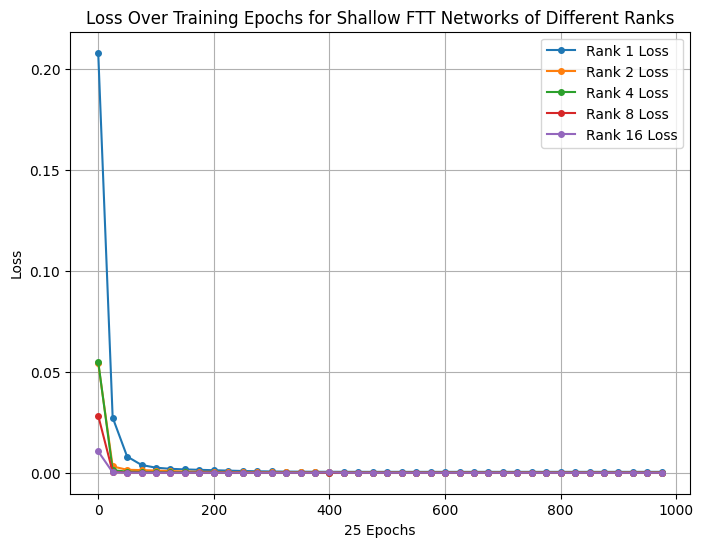

In [84]:
# Number of epochs
n_epochs = len(training_dict["Rank 1"])

# Select the epochs to plot (0th, 100th, 200th, etc.)
epochs_to_plot = range(0, n_epochs, 25)

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank at the selected intervals with smaller "o" markers
plt.plot(epochs_to_plot, [training_dict["Rank 1"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 1 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 2"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 2 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 4"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 4 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 8"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 8 Loss')
plt.plot(epochs_to_plot, [training_dict["Rank 16"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 16 Loss')
# plt.plot(epochs_to_plot, [training_dict["Rank 32"][epoch] for epoch in epochs_to_plot], marker='o', markersize=4, label='Rank 32 Loss')

plt.xlabel('25 Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for Shallow FTT Networks of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'shallow_ftt_gaussian_density_regression_2D_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [85]:
# Define a list of models and corresponding ranks
models = [ftt_rank1, ftt_rank2, ftt_rank4, ftt_rank8, ftt_rank16]
ranks = [1, 2, 4, 8, 16]

# models = [ftt_rank1]
# ranks = [1]

# Define the test data grid
n = 25
test_data_x_1 = torch.linspace(-2.5, 2.5, n)
test_data_x_2 = torch.linspace(-2.5, 2.5, n)
test_data = torch.cartesian_prod(test_data_x_1, test_data_x_2)

TT-rank 1: Absolute squared error of 0.00051687 and relative squared error of 0.240192 on test data grid.
TT-rank 2: Absolute squared error of 0.00010963 and relative squared error of 0.050945 on test data grid.
TT-rank 4: Absolute squared error of 0.00000552 and relative squared error of 0.002567 on test data grid.
TT-rank 8: Absolute squared error of 0.00000337 and relative squared error of 0.001565 on test data grid.
TT-rank 16: Absolute squared error of 0.00000336 and relative squared error of 0.001559 on test data grid.


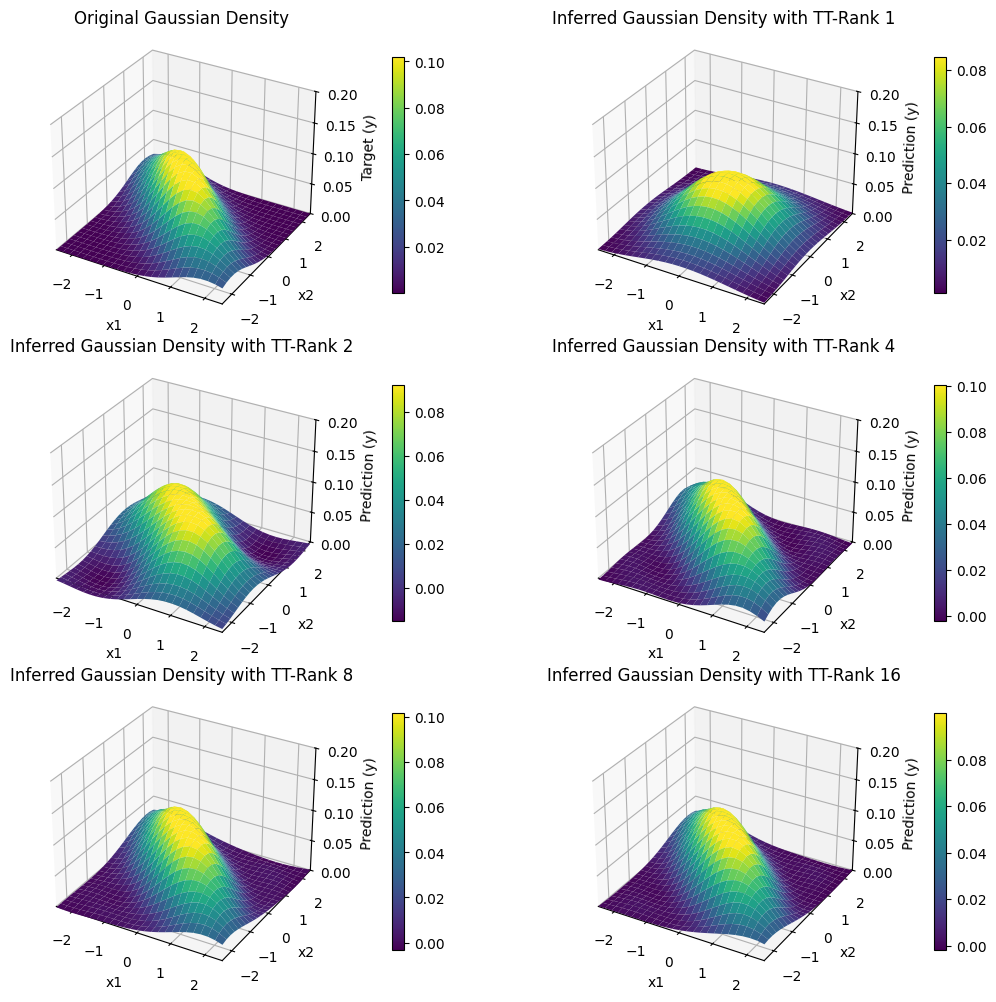

In [86]:
# Create the figure with 6 subplots (3x2 layout)
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': '3d'}, figsize=(12, 10))

# Ground truth Gaussian density (for the top-left plot)
test_target = gaussian_density(test_data, Gamma, scaling=True)

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func_shallow_net(model, test_data, test_target)
    rel_error = rel_error_func_shallow_net(model, test_data, test_target)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.8f} and relative squared error of {rel_error:.6f} on test data grid.")

# Reshape the target data into (n, n) grid form for surface plotting
test_target_np = test_target.numpy()
X1, X2 = np.meshgrid(test_data_x_1.numpy(), test_data_x_2.numpy())
Z_target = test_target_np.reshape(n, n)

# Plot 1: Original 2D Gaussian density (top-left)
ax1 = axes[0, 0]
ax1.set_title(f'Original Gaussian Density', pad=2)
norm1 = mcolors.Normalize(vmin=np.min(Z_target), vmax=np.percentile(Z_target, 95))
surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', norm=norm1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('Target (y)')
fig.colorbar(surf1, ax=ax1, shrink=0.8, pad=0.1)
ax1.set_xlim([-2.5, 2.5])
ax1.set_ylim([-2.5, 2.5])
ax1.set_zlim([0, 0.2])

# Loop through each model and rank to generate the remaining 3 plots
for i, (model, rank) in enumerate(zip(models, ranks)):
    
    # Inferred prediction using the model
    prediction = model(0, test_data)
    prediction_np = prediction.detach().numpy()

    # Reshape predicted data into (n, n) grid form for surface plotting
    Z_prediction = prediction_np.reshape(n, n)

    # Determine the subplot (for ranks 2, 4, 8)
    row = (i + 1) // 2  # 1 for 2nd row, 0 for 1st row
    col = (i + 1) % 2  # 1 for right column, 0 for left column

    # Plot: Inferred Gaussian density (from model)
    ax = axes[row, col]
    ax.set_title(f'Inferred Gaussian Density with TT-Rank {rank}', pad=2)
    norm2 = mcolors.Normalize(vmin=np.min(Z_prediction), vmax=np.percentile(Z_prediction, 95))
    surf2 = ax.plot_surface(X1, X2, Z_prediction, cmap='viridis', norm=norm2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Prediction (y)')
    fig.colorbar(surf2, ax=ax, shrink=0.8, pad=0.1)
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    ax.set_zlim([0, 0.2])

# Adjust the layout so the plots don't overlap
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'shallow_ftt_gaussian_density_regression_2D_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plots
plt.show()

##### Approximating a Gaussian density in 5D

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [40]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 6

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [41]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [43]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [45]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [48]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")


Training Run ID: Rank 2

Epoch [1/50], Loss: 0.0348, Transport Cost: 1.1948
Epoch [2/50], Loss: 0.0327, Transport Cost: 1.1721
Epoch [3/50], Loss: 0.0306, Transport Cost: 1.3178
Epoch [4/50], Loss: 0.0286, Transport Cost: 1.1777
Epoch [5/50], Loss: 0.0270, Transport Cost: 1.4824
Epoch [6/50], Loss: 0.0256, Transport Cost: 1.2976
Epoch [7/50], Loss: 0.0241, Transport Cost: 1.3074
Epoch [8/50], Loss: 0.0231, Transport Cost: 1.4986
Epoch [9/50], Loss: 0.0221, Transport Cost: 1.7762
Epoch [10/50], Loss: 0.0210, Transport Cost: 1.4385
Epoch [11/50], Loss: 0.0202, Transport Cost: 1.5681
Epoch [12/50], Loss: 0.0194, Transport Cost: 1.4508
Epoch [13/50], Loss: 0.0186, Transport Cost: 1.5435
Epoch [14/50], Loss: 0.0180, Transport Cost: 1.8318
Epoch [15/50], Loss: 0.0174, Transport Cost: 1.7535
Epoch [16/50], Loss: 0.0169, Transport Cost: 1.4878
Epoch [17/50], Loss: 0.0164, Transport Cost: 1.6596
Epoch [18/50], Loss: 0.0160, Transport Cost: 1.9134
Epoch [19/50], Loss: 0.0156, Transport Cost: 1.

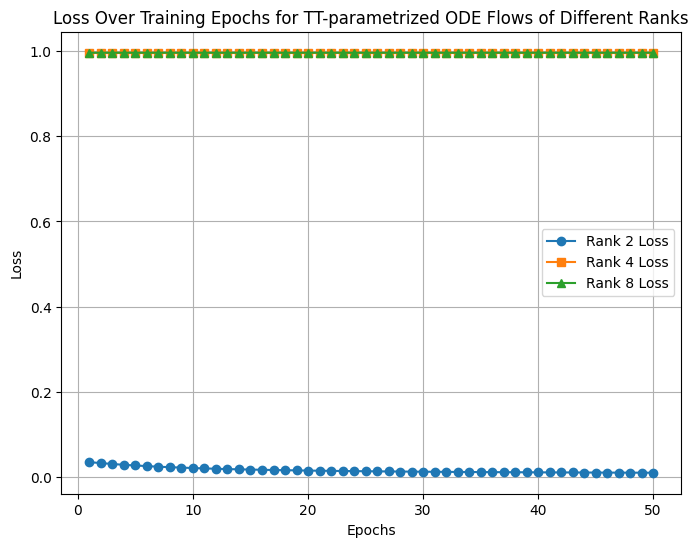

In [49]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

2. **Fourier basis:**

    Next, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Fourier  basis of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [ ]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 6

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.), normalize=True, period=4)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

In [ ]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [ ]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [ ]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [ ]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")

In [ ]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

3. **B-Splines:**

    Now, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using **B-Splines of dimension 8**. The experiment is conducted for **FTTs of ranks 2, 4, 8**. 

In [ ]:
# Test implementation of B-spline basis
degree = 3
d = 6
bases = [
        BSpline1D(torch.linspace(-5, 5, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

In [ ]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [ ]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)

# Gamma = torch.tensor([[1., 0.], [0.,1.]])
Gamma = torch.eye(5)

data , target = generate_gaussian_data(d=5, Gamma=Gamma, n_samples=n_samples, scaling=True)

# Initialize FTTs of rank 2, 4, 8
ftt_rank2 = FuncTT(d_in=5, d_out=1, bases=bases, rank=2, time_dependent=True)
ftt_rank4 = FuncTT(d_in=5, d_out=1, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=5, d_out=1, bases=bases, rank=8, time_dependent=True)

model_rank2 = ExtendedFlowODE(ftt_rank2)
model_rank4 = ExtendedFlowODE(ftt_rank4)
model_rank8 = ExtendedFlowODE(ftt_rank8)

# Set the models to training mode and choose optimizer
model_rank2.train()
model_rank4.train()
model_rank8.train()

optimizer_rank2 = optim.AdamW(model_rank2.parameters(), lr=learning_rate)
optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

In [ ]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [ ]:
training_dict = {}
training_procedure(model_rank2, data, target, batch_size, n_epochs, optimizer_rank2, training_dict, "Rank 2")
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")

In [ ]:
# Number of epochs
n_epochs = len(training_dict["Rank 2"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 2"], marker='o', label='Rank 2 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='s', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='^', label='Rank 8 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_gaussian_density_regression_5D_training_loss_BSplines.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()